# FFT

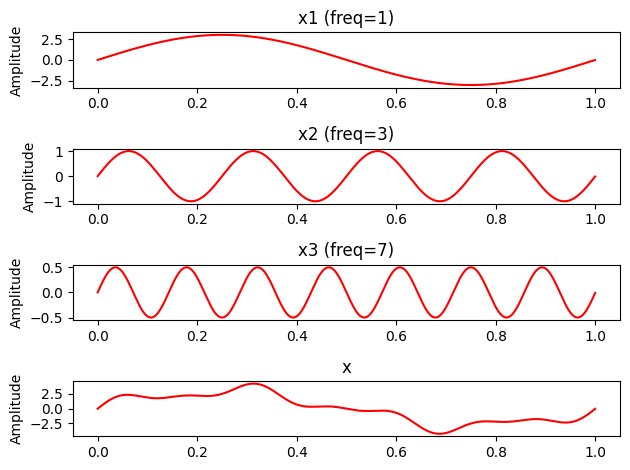

In [3]:
import matplotlib.pyplot as plt
import numpy as np


sampling_rate = 2000
ts = 1.0 / sampling_rate
t = np.arange(0,1,ts)

freq = 1.
x1 = 3 * np.sin(2*np.pi*freq*t)

freq = 4
x2 = np.sin(2*np.pi*freq*t)

freq = 7
x3 = 0.5 * np.sin(2*np.pi*freq*t)

x = x1 + x2 + x3

plt.figure()
plt.subplot(4, 1, 1)
plt.plot(t, x1, 'r')
plt.ylabel('Amplitude')
plt.title("x1 (freq=1)")

plt.subplot(4, 1, 2)
plt.plot(t, x2, 'r')
plt.ylabel('Amplitude')
plt.title("x2 (freq=3)")

plt.subplot(4, 1, 3)
plt.plot(t, x3, 'r')
plt.ylabel('Amplitude')
plt.title("x3 (freq=7)")

plt.subplot(4, 1, 4)
plt.plot(t, x, 'r')
plt.ylabel('Amplitude')
plt.title("x")

plt.tight_layout()
plt.show()

/Users/kotarohara/miniforge3/envs/cs702-2024/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kotarohara/miniforge3/envs/cs702-2024/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


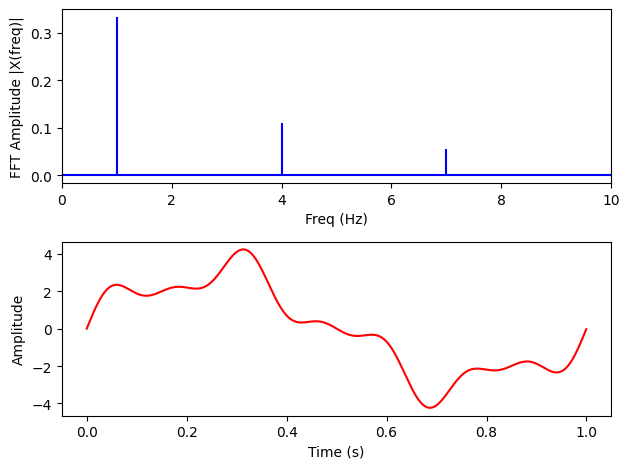

In [4]:
from numpy.fft import fft, ifft

X = fft(x)
N = len(X)
n = np.arange(N)
T = N / sampling_rate
freq = n/T

plt.figure()
plt.subplot(211)

plt.stem(freq, np.abs(X) / np.sum(np.abs(X)), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(212)
recovered_x = ifft(X)
plt.plot(t, recovered_x, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Audio Signal Processing

In [5]:
import IPython

wav_file = 'sound.wav'
IPython.display.Audio(wav_file)

In [6]:
import wave
import numpy as np
import matplotlib.pyplot as plt

wav_file = 'sound.wav'

with wave.open(wav_file) as wav:
    sampling_frequency = wav.getframerate() # Hz
    sample_size = wav.getsampwidth() # Byte
    num_channels = wav.getnchannels()
    num_samples = wav.getnframes()
    waveform = wav.readframes(num_samples)
    waveform = np.frombuffer(waveform, dtype=np.int16)

print(f"Sampling Frequency: {sampling_frequency} [Hz]")
print(f"Sample Size: {sample_size} [Byte]")
print(f"Number of Channels: {num_channels}")
print(f"Number of Samples: {num_samples}")

# Sampling Frequency: 48000 [Hz]
# Sample Size: 2 [Byte]
# Number of Channels: 2
# Number of Samples: 159744

Sampling Frequency: 48000 [Hz]
Sample Size: 2 [Byte]
Number of Channels: 2
Number of Samples: 159744


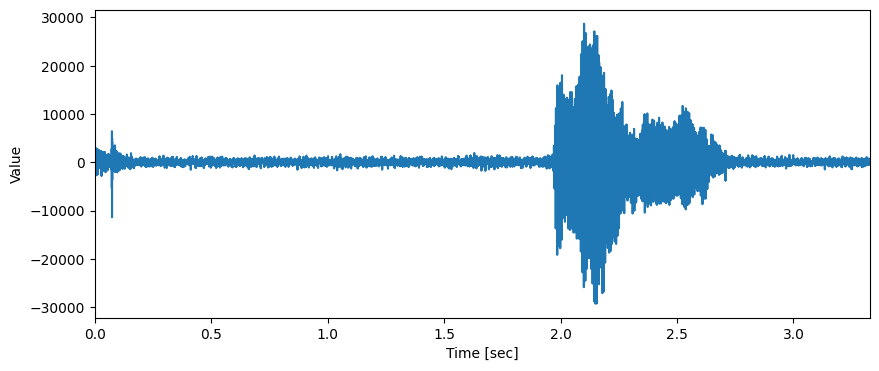

In [7]:
# Extract the first channel
ch0 = waveform[0::2]

# Down sample from 48000 to 16000.
sampling_frequency = sampling_frequency / 3
num_samples = round(num_samples / 3)
ch0 = ch0[::3]

time_axis = np.arange(num_samples) / sampling_frequency

plt.figure(figsize=(10, 4))
plt.plot(time_axis, ch0)
plt.xlabel("Time [sec]")
plt.ylabel("Value")
plt.xlim([0, num_samples / sampling_frequency])
plt.show()

## Spectral Decomposition with FFT

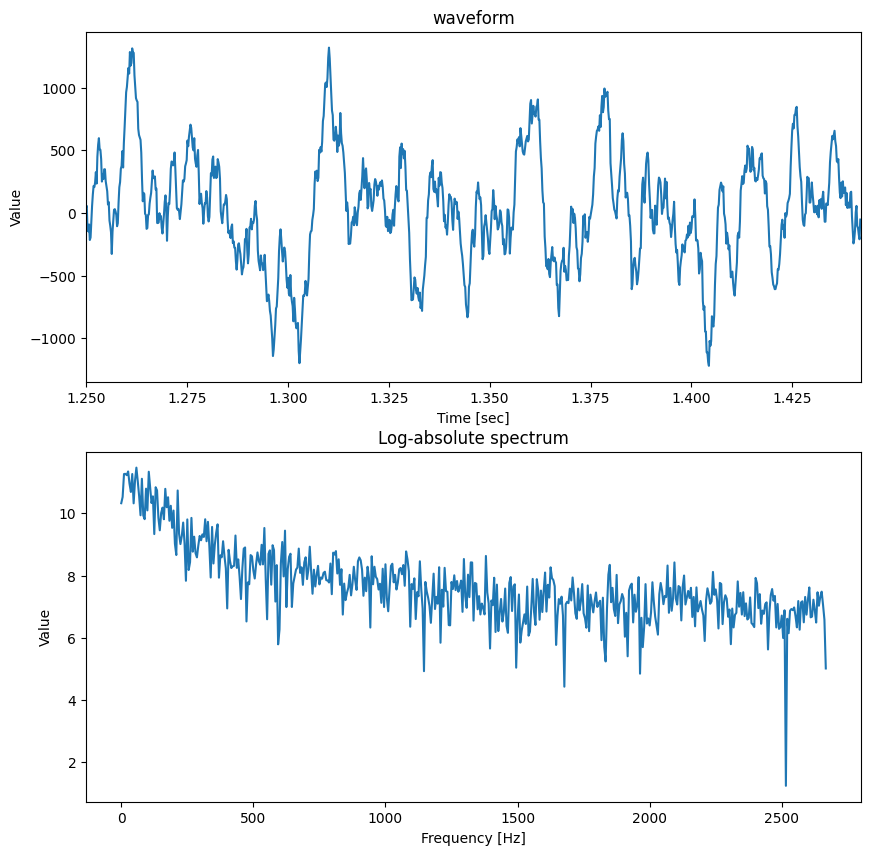

In [8]:
# Extract the first channel
ch0 = waveform[0::2]

# Down sample from 48000 to 16000.
sampling_frequency = sampling_frequency / 3
num_samples = round(num_samples / 3)
ch0 = ch0[::3]

target_time = 1.25
fft_size = 1024
target_index = np.int16(target_time * sampling_frequency)
frame = ch0[target_index:target_index + fft_size]
spectrum = np.fft.fft(frame)
absolute = np.abs(spectrum)
absolute = absolute[:np.int16(fft_size/2) + 1]
log_spectrum = np.log(absolute + 1e-7)

plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
time_axis = target_time + np.arange(fft_size) / sampling_frequency

plt.plot(time_axis, frame)

plt.title('waveform')
plt.xlabel('Time [sec]')
plt.ylabel('Value')

plt.xlim([target_time, target_time + fft_size / sampling_frequency])

plt.subplot(2, 1, 2)
freq_axis = np.arange(np.int16(fft_size /2) + 1) * sampling_frequency / fft_size
plt.plot(freq_axis, log_spectrum)
plt.title('Log-absolute spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Value')
plt.show()

# Mel filter bank

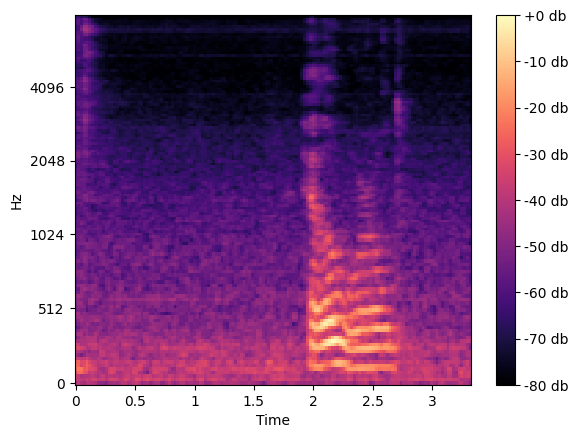

In [11]:
import librosa.display

import matplotlib.pyplot as plt
import numpy as np

y, sr = librosa.load("sound.wav")
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

fig, ax = plt.subplots()
S_db = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_db, x_axis="time", y_axis="mel", sr=sr, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format="%+2.0f db")
plt.show()

# Window Function

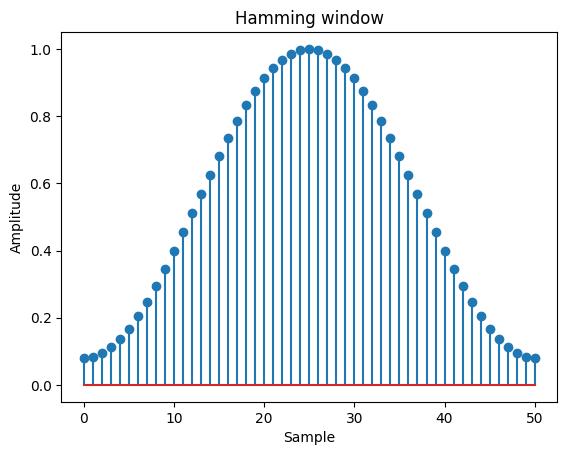

In [13]:
from scipy import signal
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt

window = signal.windows.hamming(51)
plt.stem(window)
plt.title("Hamming window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

# Spectrogram

In [14]:
num_samples = len(y)
frame_duration = 25 # [ms]
frame_shift_duration = 10 # [ms]

frame_size = int(sampling_frequency * frame_duration / 1000)
frame_shift = int(sampling_frequency * frame_shift_duration / 1000)

fft_size = 512
num_frames = (num_samples)

num_frames = (num_samples - frame_size) // frame_shift + 1
print(f"Number of frames: {num_frames}")

Number of frames: 1383


In [15]:
spectrogram = np.zeros((num_frames, int(fft_size / 2) + 1))

for frame_idx in range(num_frames):
    start_index = frame_idx * frame_shift
    frame = y[start_index:start_index + frame_size].copy()
    frame = frame * signal.windows.hamming(frame_size)
    spectrum = fft(frame, n=fft_size)
    absolute = np.abs(spectrum)
    absolute = absolute[:int(fft_size/2) + 1]
    log_absolute = np.log(absolute + 1e-7)
    spectrogram[frame_idx, :] = log_absolute

ValueError: x and y must have same first dimension, but have shapes (1024,) and (73383,)

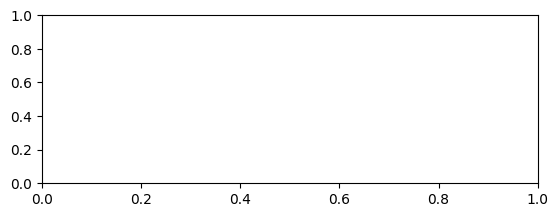

In [16]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(time_axis, y)
plt.xlabel("Time [sec]")
plt.ylabel("Value")

plt.subplot(2, 1, 2)
spectrogram -= np.max(spectrogram)
vmax = np.abs(np.min(spectrogram)) * 0.0
vmin = -np.abs(np.min(spectrogram)) * 0.7

plt.imshow(spectrogram.T[-1::-1,:],
           extent=[0, num_samples / sampling_frequency, 0, sampling_frequency / 2],
           vmax=vmax, vmin=vmin, aspect='auto')
plt.title("Spectrogram")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.tight_layout()
plt.show()

# Filter Bank

/var/folders/4_/vrr8kzqn5b9dxsprxn13022m0000gn/T/ipykernel_23060/136258918.py:1: DeprecationWarning: Importing triang from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.triang' or the convenience function 'scipy.signal.get_window' instead.
  tri = signal.triang(33)


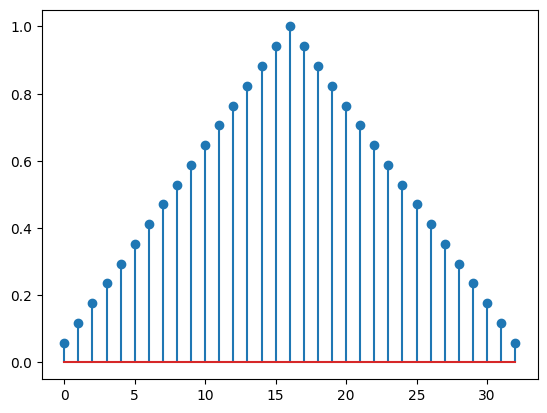

In [17]:
tri = signal.triang(33)
# tri = tri / np.sum(tri)
plt.stem(tri)
plt.show()

In [18]:
feature = np.zeros(log_absolute.shape[0])
np.shape(feature)

(257,)

In [23]:
# Create filter banks
dim_spectrum = 257
num_banks = 7
step_size = 32
bank_size = 64

filter_banks = []
for k in range(num_banks):
    bank = np.zeros(dim_spectrum)
    tri = signal.triang(bank_size)

    f_low = k * step_size
    f_high = f_low + bank_size

    bank[f_low:f_high] = tri

    filter_banks.append(bank)

/var/folders/4_/vrr8kzqn5b9dxsprxn13022m0000gn/T/ipykernel_23060/1748061738.py:10: DeprecationWarning: Importing triang from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.triang' or the convenience function 'scipy.signal.get_window' instead.
  tri = signal.triang(bank_size)


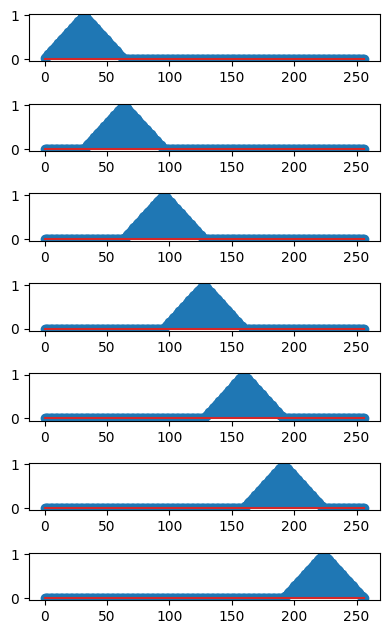

In [24]:
plt.figure(figsize=(4, 8))
for k, bank in enumerate(filter_banks, 1):
    plt.subplot(9, 1, k)
    plt.stem(bank)
plt.tight_layout()
plt.show()

In [25]:
features = []
for bank in filter_banks:
    feature = log_absolute * bank
    features.append(feature)

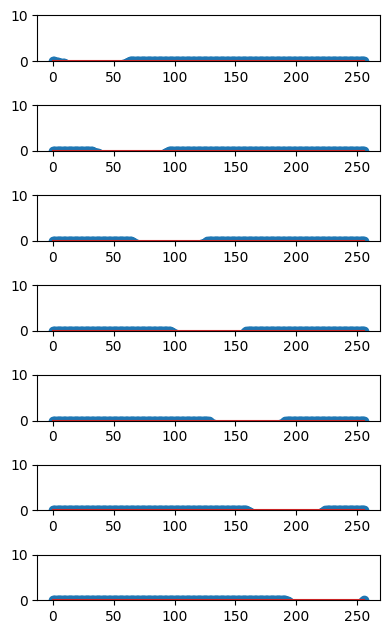

In [26]:
plt.figure(figsize=(4, 8))
for k, bank in enumerate(features, 1):
    plt.subplot(9, 1, k)
    plt.stem(bank)
    plt.ylim([0, 10])
plt.tight_layout()
plt.show()